In [9]:
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import joblib
import json
import numpy as np

sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:

data_dir = "/mnt/data/stephana93dm/storage/projects/alternative_clustering/alternative_clustering/datasets/"
load_dir = os.path.join(data_dir, "NR-Objects")
save_dir = os.path.join(data_dir, "processed")

json_dir = os.path.join(load_dir, "scenes")
png_dir = os.path.join(load_dir, "images")

In [11]:
df = []

i = 0
for file_name in os.listdir(json_dir):
    # i = i + 1
    # if i > 3:
    #     break
    json_file = os.path.join(json_dir, file_name)
    if not file_name.endswith(".json") or "scenes" in file_name:
        continue
    with open(json_file, 'r') as f:
        data = json.load(f)
    # print(data["objects"]) 
    if "objects" not in data:
        print(json_file)
        print(data)
    assert len(data["objects"]) == 1
    row = {
        "image_filename": file_name,
        "shape": data["objects"][0]["shape"],
        "material": data["objects"][0]["material"],
        "colour": data["objects"][0]["color"],
    }
    df.append(row)

df = pd.DataFrame(df)
df.head()

,image_filename,shape,material,colour
0,CLEVR_train_004805.json,cube,metal,gray
1,CLEVR_train_002941.json,cylinder,metal,blue
2,CLEVR_train_003517.json,sphere,metal,yellow
3,CLEVR_train_007883.json,sphere,rubber,gray
4,CLEVR_train_002484.json,sphere,rubber,red


In [12]:
from sklearn.preprocessing import LabelEncoder

shape_le = LabelEncoder()
material_le = LabelEncoder()
colour_le = LabelEncoder()

df["shape_clusters"] = shape_le.fit_transform(df["shape"])
df["material_clusters"] = material_le.fit_transform(df["material"])
df["colour_clusters"] = colour_le.fit_transform(df["colour"])

In [13]:
cluster_to_name = {
    "shape": {i: name for i, name in enumerate(shape_le.classes_)},
    "material": {i: name for i, name in enumerate(material_le.classes_)},
    "colour": {i: name for i, name in enumerate(colour_le.classes_)},
}
cluster_to_name

{'shape': {0: 'cube', 1: 'cylinder', 2: 'sphere'},
 'material': {0: 'metal', 1: 'rubber'},
 'colour': {0: 'blue',
  1: 'gray',
  2: 'green',
  3: 'purple',
  4: 'red',
  5: 'yellow'}}

In [14]:
import shutil


save_folder = os.path.join(save_dir, "NR-Objects")
image_save_folder = os.path.join(save_folder, "images")
clustering_save_folder = os.path.join(save_folder, "clustering")
os.makedirs(image_save_folder, exist_ok=True)
os.makedirs(clustering_save_folder, exist_ok=True)

with open(os.path.join(save_folder, "cluster_to_name.json"), "w") as f:
    json.dump(cluster_to_name, f)

for cluster_name in ["shape", "material", "colour"]:
    dictionary = {}
    for idx, row in df.iterrows():
        name = row["image_filename"].replace(".json", ".png")
        dictionary[name] = row[f"{cluster_name}_clusters"]

        src = os.path.join(png_dir, name)
        dst = os.path.join(image_save_folder, name)
        shutil.copyfile(src, dst)
    
    save_file = os.path.join(clustering_save_folder, f"clusters_{cluster_name}.json")
    with open(save_file, "w") as f:
        json.dump(dictionary, f)

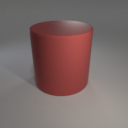

In [15]:
import PIL.Image as Image

def display_image(image):
    image = Image.open(image)
    image.show()

display_image(os.path.join(png_dir, "CLEVR_train_000000.png"))